Progetto: **Classificazione di testi descrittivi per destinazione d'uso, inerenti ai beni sottoposti ad aste giudiziarie italiane.**

Studente: **Alessandro Monolo** | *10439147*

Relatore: Marco Brambilla

Referente aziendale: Simone Redaelli

Master: Data Science & Artificial Intelligence

Università: Politecnico di Milano

<hr style="border:1px solid black">

## Predizioni per Text Classification con FastText


- **1 Preparazione del data frame per il modello FastText, ricavando per ogni osservazione la _label_Class, cosi da poter predirre ogni classe per ogni osservazione presente nel dataframe;**
    - Inoltre, in questo caso, è stato impiegato un data frame che non ha al proprio interno ne typos ne cifre nelle varie osservazioni;


- **2 La fase di predizione è stata eseguita con il modello elaborato da Facebook chiamato FastText**.
    - Il quale esegue una **text classification** per le sette categorie di beni presenti nel data frame. Anche in questo caso il data frame è altamente sbilanciato tra le varie classi presenti, quindi per far frontre a questa problematica si utilizza **Stratified K Fold** con 5 folds.


- **3. Dopo l'esecuzione del modello, si valutano le predizioni con le metriche di valutazione:**
    - **Precision, Recall & F1 Score**;
    - **Confusion matrix**, per il controllo del **numero di predizioni corrette/errate** per ogni classe;
    - **Classification report** per il controllo della metrica **F1 score relativa ad ogni classe**.


- **4. Conclusioni.**


- Link fasttext for text classification: https://fasttext.cc/docs/en/supervised-tutorial.html
- Link post 1 medium: https://towardsdatascience.com/word2vec-glove-and-fasttext-explained-215a5cd4c06f
- Link post 2 medium: https://medium.com/towards-data-science/fasttext-for-text-classification-a4b38cbff27c
- Link post 3 medium: - Link: https://medium.com/@rukshanjayasekara/text-classification-with-fasttext-5cac26ce7bc6
- Link github for text classification using fasttext: https://github.com/codebasics/nlp-tutorials/blob/main/18_fasttext_classification/fasttext_tutorial.ipynb

<hr style="border:1px solid black">

**Importo le librerie che mi servono:**

In [1]:
import warnings
import fasttext
from cryptography.utils import CryptographyDeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=CryptographyDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import string
import unicodedata
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedKFold, cross_val_score
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import spacy
import gensim.downloader as api
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import random
import csv

#### Set pandas options:

In [3]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 1000
pd.options.display.float_format = '{:.4f}'.format
pd.options.mode.chained_assignment = None

**Importo file CSV**

In [4]:
df = pd.read_csv("D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\13_Dataset_FastText\\Dataset_FastText.csv")

### 1 - Preparazione del data frame per il modello FastText

- **Mappo la colonna destinazione d'uso con le categorie in formato stringa**

In [5]:
mapping = {0: "AGRICULTURAL_BUILDING", 1: "HOTEL", 2: "INDUSTRIAL", 3: "LAND", 4: "RESIDENTIAL", 5: "RETAIL", 6: "STORAGE"}
df['Destinazione_Uso_FastText'] = df['Destinazione_Uso_Encoded'].map(mapping)
df['Destinazione_Uso_FastText'] = df['Destinazione_Uso_FastText'].str.lower()

#### Creo una nuova colonna contenente sia la label della classe sia la descrizione, utile per trainare il modello con FastText

In [6]:
df["Destinazione_Uso_FastText"] = "__label__" + df["Destinazione_Uso_FastText"].astype(str)

#### Creo una nuova colonna contenente sia la label della classe sia la descrizione, utile per trainare il modello con FastText

In [7]:
df["FastText_Data"] = df["Destinazione_Uso_FastText"] + " " + df["Descrizione_Bene_FastText"]

#### Elimino la colonna che non mi serve più

In [8]:
colonne_to_drop = ["Destinazione_Uso_Encoded", "Descrizione_Bene_FastText"]
df.drop(columns=colonne_to_drop, inplace=True)

### 2 - Text classification con Stratified K Fold - FastTExt con la variabile testuale senza cifre e senza typos

In [9]:
n_splits = 5

stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

precision_scores = []
recall_scores = []
f1_scores = []

all_test_indices = []
all_predictions = []  

for train_index, test_index in stratified_kf.split(df['FastText_Data'], df['Destinazione_Uso_FastText']):
    X_train, X_test = df['FastText_Data'].iloc[train_index], df['FastText_Data'].iloc[test_index]
    y_train, y_test = df['Destinazione_Uso_FastText'].iloc[train_index], df['Destinazione_Uso_FastText'].iloc[test_index]

    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    test_df = pd.DataFrame({'text': X_test, 'label': y_test})

    train_df.to_csv('D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\13_Dataset_FastText\\Descrizione_FastText_4.train.txt', 
                    sep='\t', index=False, header=False)
    test_df.to_csv('D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\13_Dataset_FastText\\Descrizione_FastText_4.test.txt', 
                   sep='\t', index=False, header=False)

    model = fasttext.train_supervised(input='D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\13_Dataset_FastText\\Descrizione_FastText_4.train.txt', 
                                      autotuneValidationFile='D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\13_Dataset_FastText\\Descrizione_FastText_4.test.txt')

    results = model.test('D:\\Master_Cefriel_DS_AI_Monolo\\0_Project_Work\\Dataset\\13_Dataset_FastText\\Descrizione_FastText_4.test.txt')

    predictions = [model.predict(str(text), k=1)[0][0] for text in X_test]
    
    precision = results[1]  
    recall = results[2]  
    f1 = 2 * (precision * recall) / (precision + recall)  

    print(f"Precision: {round(precision, 2)}")
    print(f"Recall: {round(recall, 2)}")
    print(f"F1 Score: {round(f1, 2)}")
    print("\n")

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    all_test_indices.extend(test_index)
    all_predictions.extend(predictions)

avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)

print("Overall evaluation metrics:")
print("Macro - Precision:", round(avg_precision, 2))
print("Macro - Recall:", round(avg_recall, 2))
print("Macro - F1 Score:", round(avg_f1, 2))

Precision: 0.88
Recall: 0.44
F1 Score: 0.59


Precision: 0.89
Recall: 0.44
F1 Score: 0.59


Precision: 0.88
Recall: 0.44
F1 Score: 0.59


Precision: 0.88
Recall: 0.44
F1 Score: 0.59


Precision: 0.88
Recall: 0.44
F1 Score: 0.59


Overall evaluation metrics:
Macro - Precision: 0.88
Macro - Recall: 0.44
Macro - F1 Score: 0.59


### 3- Valutazione del modello

- **Check dell'accuracy raggiunta dal modello, con check della F1 Score per ogni classe del data frame:**

In [10]:
classification_report_str = classification_report(df['Destinazione_Uso_FastText'].iloc[all_test_indices],
                                                  all_predictions, 
                                                  zero_division=0)

print(classification_report_str)

                                precision    recall  f1-score   support

__label__agricultural_building       0.19      0.01      0.02       550
                __label__hotel       0.82      0.17      0.28       560
           __label__industrial       0.57      0.19      0.28      2269
                 __label__land       0.84      0.78      0.81      5801
          __label__residential       0.90      0.97      0.94    132176
               __label__retail       0.76      0.66      0.70      7743
              __label__storage       0.71      0.45      0.55     16904

                      accuracy                           0.88    166003
                     macro avg       0.69      0.46      0.51    166003
                  weighted avg       0.87      0.88      0.87    166003



- **Confusion matrix per controllare il numero di predizioni corrette per ogni classe di destinazione d'uso:**

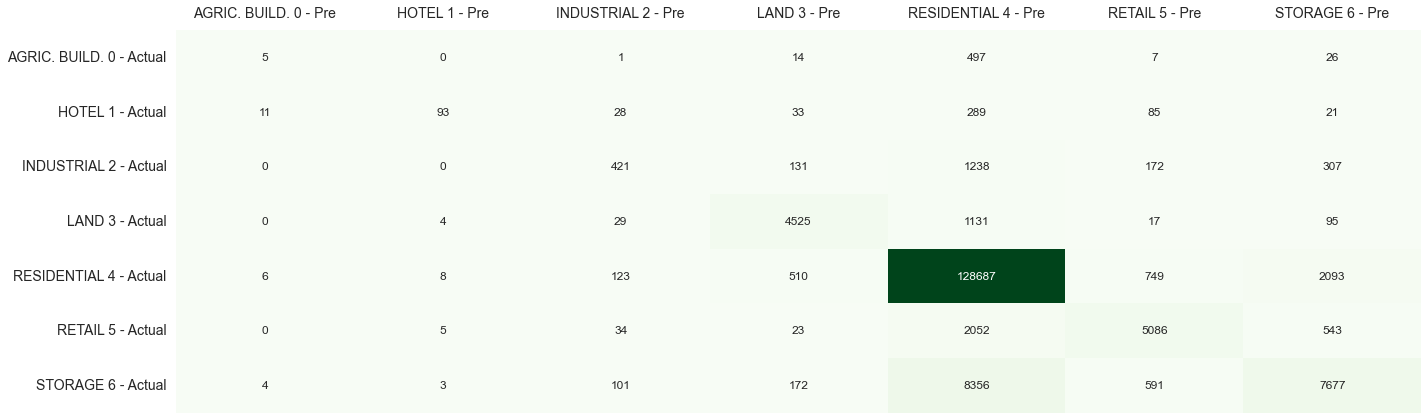

In [11]:
cm_pred = confusion_matrix(df['Destinazione_Uso_FastText'].iloc[all_test_indices], 
                           all_predictions)

cm_pred = pd.DataFrame(cm_pred,
                       index=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                       columns = ['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'])

# Mostro la confusion matrix su una heatmap:
sns.set(rc={'figure.figsize':(20,6)})
heatmap = sns.heatmap(cm_pred, 
            annot=True, 
            cmap="Greens", 
            fmt="d", 
            xticklabels=['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'], 
            yticklabels=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                     cbar=False)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)

plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.tight_layout()
plt.show()

In [14]:
print("Numero predizioni corrette: ", 5+93+421+4525+128687+5086+7677)
print("Numero predizioni sbagliate: ", 166003-(5+93+421+4525+128687+5086+7677))

Numero predizioni corrette:  146494
Numero predizioni sbagliate:  19509


### Conclusioni

- La **text classification** eseguita con FastText risulta essere finora la **migliore**.
    - Raggiungendo una **F1 Score** pari a **0.59** ed una **Precision** pari a **0.88**, superando quindi quella ricavata da **TFIDF con Logistic Rregression**, la quale era pari a **0.56**;


- Inoltre, im questo caso, il **numero complessivo di errori** è pari a **19.509** osservazioni sbagliate;


- Le **prime tre classi** ("agricultural building", "hotel", "industrial") risultano essere **inferiori al 50%**, particolarmente la classe **"Agricultural Building"** che è pari a **2%**, mentre le **alre due** pari al **28%** e **28%**.


- Pertanto, l'utilizzo del modello **FastTetx per la text classification** risulta essere la **miglior soluzione provata finora**; 